<a href="https://colab.research.google.com/github/42697387/Aprendizaje-Automatico-2/blob/main/AA2_TP2_MLP_KAN_HerediaMartinGaspar1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### **TP2 AA2 MLP vs KAN**

**Martin Gaspar Heredia**

Tema: **Comparación entre MLP (Perceptrón Multicapa) y KAN (Kolmogorov-Arnold Networks) en problemas de regresión**

  * Utilice este notebook como su diario de aprendizaje en esta materia.
  * Mencione las herramientas utilizadas.
  * Describa sus dificultades y como pudo sortearlas.
  * Grafique las curvas de entrenamiento y testeo para cada configuración probada en sus modelos.

### **Objetivos:**

1.  Generar un conjunto de datos sintéticos para un problema de regresión.
2.  Implementar y evaluar una **MLP de una capa oculta** en diferentes configuraciones.
3.  Implementar y evaluar una **red KAN** en diferentes configuraciones.
4.  Analizar los casos de **underfitting**, **sobreajuste (overfitting)** y una **solución aceptable** en ambos modelos.

### **1. Generación de Datos**

  - Crear una función que genere un dataset sintético con:
      - Al menos **4 features numéricas** (generadas aleatoriamente, con distribuciones variadas: normales, uniformes, etc.).
      - **1 target continuo** (generado mediante una combinación **no** lineal de las features + ruido gaussiano).
      - Ejemplo:

In [ ]:
import numpy as np
np.random.seed(42)
X = np.random.randn(1000, 4) # 1000 muestras, 4 features
y = 2 * X[:, 0] + np.sin(X[:, 1]) + np.cos(X[:, 2]) * X[:, 3] + 0.1 * np.random.randn(1000)

- **Dividir los datos** en entrenamiento (70%) y test (30%).

> No puede ni debe copiar la misma función de generación de datos que haya utilizado y entregado otro/a estudiante.

#### **Explicación de la Generación de Datos**

Para este trabajo, se creará un conjunto de datos sintético que simule un problema de regresión complejo y no lineal. El objetivo es tener un entorno controlado donde conozcamos la "verdad" subyacente que los modelos (MLP y KAN) intentarán aprender.

Se generarán 4 características (features) con distintas distribuciones estadísticas para asegurar una rica variedad en los datos de entrada:

  * **Feature 1**: Distribución Normal estándar.
  * **Feature 2**: Distribución Uniforme entre -2 y 2.
  * **Feature 3**: Distribución Normal con media 5 y desviación estándar 2.
  * **Feature 4**: Distribución Exponencial.

La variable **objetivo (target)** se calculará como una combinación no lineal de estas características, a la que se le añadirá un ruido gaussiano. Esta no linealidad es clave para poner a prueba la capacidad de aproximación de las redes neuronales. La función elegida es:

$$y = \log(|X_0| + 1) + X_1^3 - \cos(X_2 \cdot X_3) + \text{ruido}$$

Finalmente, el conjunto de datos se dividirá en un 70% para entrenamiento y un 30% para testeo, una práctica estándar para evaluar si el modelo puede generalizar a datos no vistos.

Dimensiones de los datos de entrenamiento (X_train): (1400, 4)
Dimensiones de los datos de prueba (X_test): (600, 4)
Dimensiones del target de entrenamiento (y_train): (1400,)
Dimensiones del target de prueba (y_test): (600,)


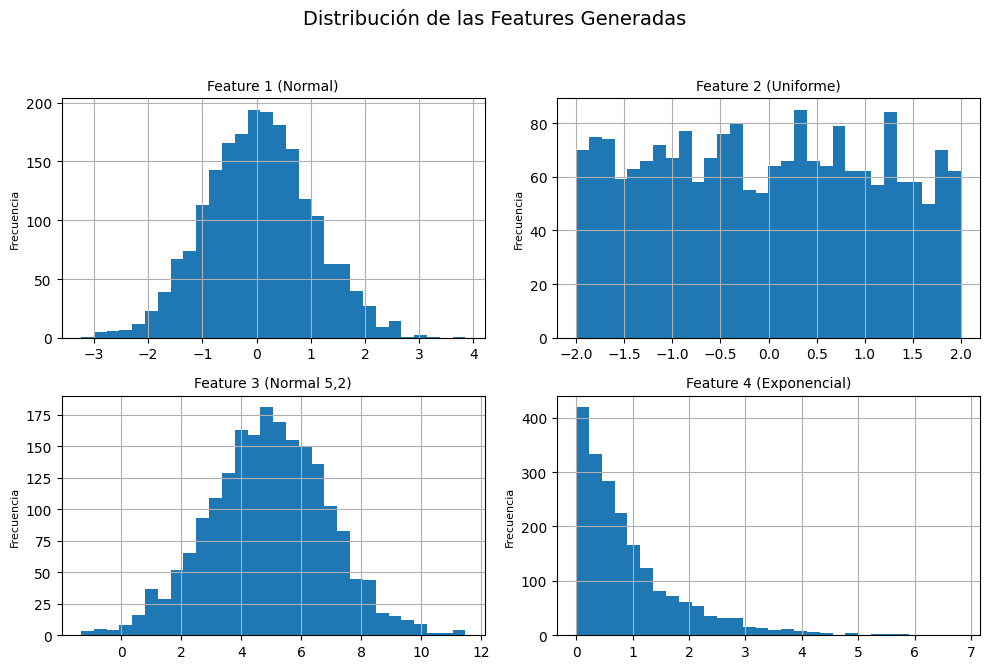

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import torch

# --- 1. Generación de Datos Sintéticos ---

def generar_datos_sinteticos(n_muestras=2000, seed=42):
    """
    Genera un conjunto de datos sintéticos con 4 features y 1 target no lineal.

    Args:
        n_muestras (int): Número de muestras a generar.
        seed (int): Semilla para la reproducibilidad.

    Returns:
        tuple: Un tuple conteniendo X (features) e y (target).
    """
    # Establecer la semilla para resultados consistentes
    np.random.seed(seed)

    # Generar 4 features con distribuciones variadas
    X1 = np.random.randn(n_muestras)      # Normal estándar
    X2 = np.random.uniform(-2, 2, n_muestras) # Uniforme
    X3 = np.random.normal(5, 2, n_muestras) # Normal con media y std específicas
    X4 = np.random.exponential(1, n_muestras) # Exponencial

    # Combinar las features en una sola matriz
    X = np.vstack([X1, X2, X3, X4]).T

    # Generar el target 'y' con una combinación no lineal de las features + ruido
    # La función es compleja para desafiar a los modelos
    y = np.log(np.abs(X[:, 0]) + 1) + np.power(X[:, 1], 3) - np.cos(X[:, 2] * X[:, 3]) + np.random.randn(n_muestras) * 0.5

    return X, y

# Generar los datos
X, y = generar_datos_sinteticos()

# Escalar los datos es una buena práctica para redes neuronales
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
# Usamos stratify si tuviéramos un problema de clasificación, pero en regresión no es necesario.
# random_state asegura que la división sea siempre la misma.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Imprimir las dimensiones para verificar
print("Dimensiones de los datos de entrenamiento (X_train):", X_train.shape)
print("Dimensiones de los datos de prueba (X_test):", X_test.shape)
print("Dimensiones del target de entrenamiento (y_train):", y_train.shape)
print("Dimensiones del target de prueba (y_test):", y_test.shape)

# Visualización de las distribuciones de las features
df = pd.DataFrame(X, columns=['Feature 1 (Normal)', 'Feature 2 (Uniforme)', 'Feature 3 (Normal 5,2)', 'Feature 4 (Exponencial)'])
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()
features = list(df.columns)

for i in range(len(features)):
    df[features[i]].hist(ax=axes[i], bins=30)
    axes[i].set_title(features[i], fontsize=10)
    axes[i].set_ylabel("Frecuencia", fontsize=8)

plt.suptitle('Distribución de las Features Generadas', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* **Feature 1 (Normal)**: Sigue una distribución normal estándar (media 0, desviación 1), simulando un atributo común en datos naturales.
  * **Feature 2 (Uniforme)**: Sus valores se distribuyen de manera equitativa entre -2 y 2, útil para representar variables con límites definidos.
  * **Feature 3 (Normal 5,2)**: Distribución normal con media 5 y desviación 2, representa una característica con un valor central distinto de cero.
  * **Feature 4 (Exponencial)**: Modela procesos donde los eventos ocurren a una tasa constante, con muchos valores bajos y pocos valores altos.

### **2. Entrenamiento de una MLP (1 capa oculta)**

Usar `PyTorch`/`TensorFlow` para implementar una MLP con:

  - **Función de activación ReLU** (u otra no lineal).
  - **Optimizador:** Adam o SGD.
  - **Métrica de evaluación:** Error Cuadrático Medio (MSE).

**Configuraciones a probar:**

1.  **Underfitting:**
      - Pocas neuronas en la capa oculta (ej: 2 neuronas).
      - Entrenar con muy pocas épocas (ej: 10).
      - Mostrar gráficos de pérdida y comparar rendimiento en train/test.
2.  **Solución Aceptable:**
      - Neuronas suficientes (ej: 20-50) y épocas adecuadas (ej: 100).
      - Regularización L2 (weight decay) si es necesario.
3.  **Overfitting:**
      - Demasiadas neuronas (ej: 200) o muchas épocas (ej: 1000).
      - Sin regularización.
      - Mostrar cómo el error en entrenamiento es mucho menor que en test.

<!-- end list -->

--- Iniciando Caso 1: Underfitting ---
Epoch [1/10], Train Loss: 8.8653, Test Loss: 7.7885
Epoch [2/10], Train Loss: 7.4859, Test Loss: 6.4650
Epoch [3/10], Train Loss: 6.4428, Test Loss: 5.4648
Epoch [4/10], Train Loss: 5.6851, Test Loss: 4.7511
Epoch [5/10], Train Loss: 5.1410, Test Loss: 4.2617
Epoch [6/10], Train Loss: 4.7512, Test Loss: 3.9182
Epoch [7/10], Train Loss: 4.4725, Test Loss: 3.6919
Epoch [8/10], Train Loss: 4.2691, Test Loss: 3.5166
Epoch [9/10], Train Loss: 4.1150, Test Loss: 3.3960
Epoch [10/10], Train Loss: 3.9849, Test Loss: 3.3042


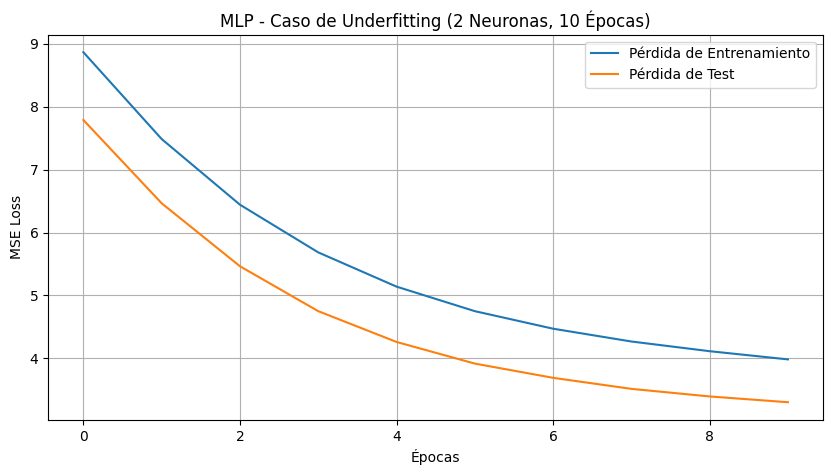

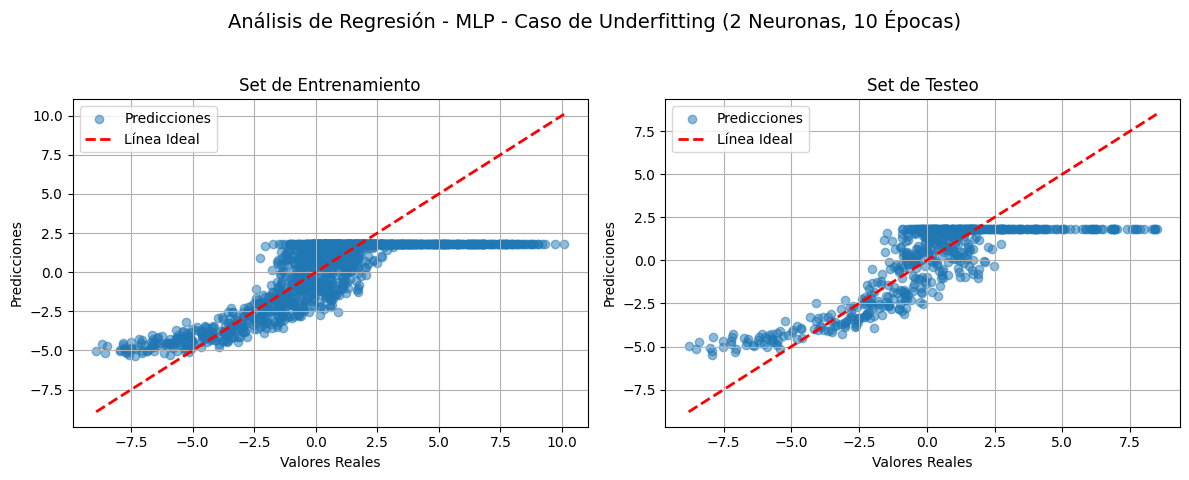


--- Iniciando Caso 2: Solución Aceptable ---
Epoch [15/150], Train Loss: 0.8403, Test Loss: 0.8086
Epoch [30/150], Train Loss: 0.5963, Test Loss: 0.6627
Epoch [45/150], Train Loss: 0.5115, Test Loss: 0.5552
Epoch [60/150], Train Loss: 0.5096, Test Loss: 0.5379
Epoch [75/150], Train Loss: 0.4724, Test Loss: 0.5045
Epoch [90/150], Train Loss: 0.4920, Test Loss: 0.5071
Epoch [105/150], Train Loss: 0.4579, Test Loss: 0.4685
Epoch [120/150], Train Loss: 0.4421, Test Loss: 0.4662
Epoch [135/150], Train Loss: 0.4621, Test Loss: 0.4880
Epoch [150/150], Train Loss: 0.4373, Test Loss: 0.4660


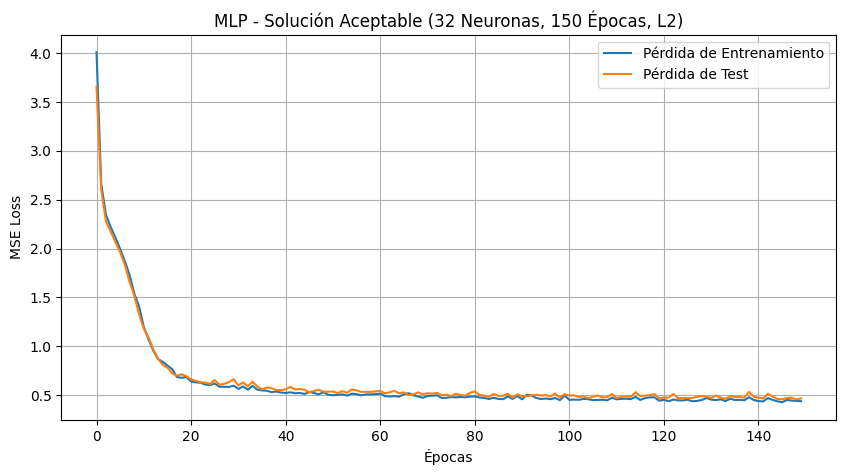

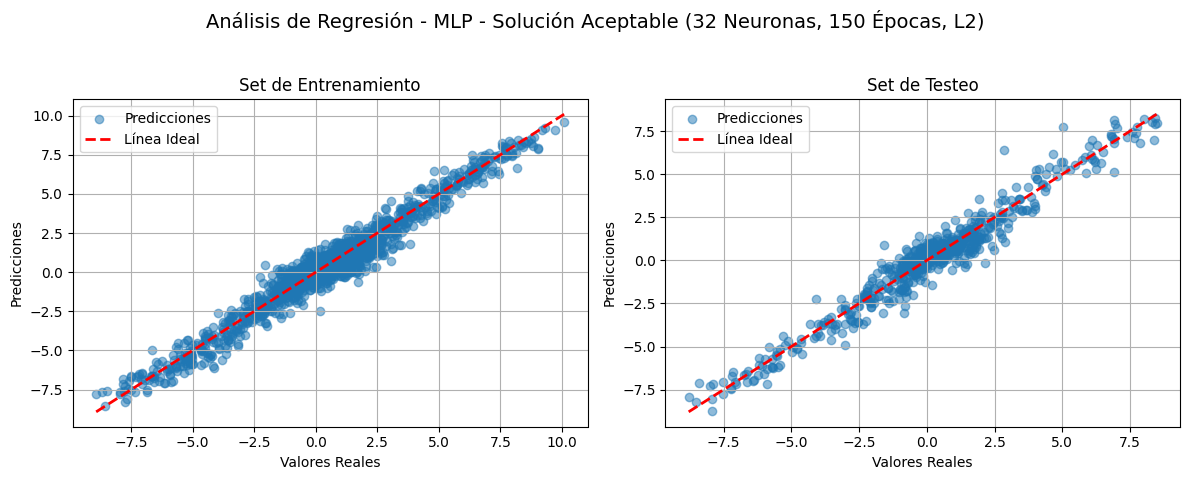


--- Iniciando Caso 3: Overfitting ---
Epoch [50/500], Train Loss: 0.4248, Test Loss: 0.4814
Epoch [100/500], Train Loss: 0.3571, Test Loss: 0.4563
Epoch [150/500], Train Loss: 0.3242, Test Loss: 0.4387
Epoch [200/500], Train Loss: 0.3074, Test Loss: 0.4539
Epoch [250/500], Train Loss: 0.2989, Test Loss: 0.4436
Epoch [300/500], Train Loss: 0.2659, Test Loss: 0.4522
Epoch [350/500], Train Loss: 0.2897, Test Loss: 0.4641
Epoch [400/500], Train Loss: 0.2547, Test Loss: 0.4490
Epoch [450/500], Train Loss: 0.2649, Test Loss: 0.4883
Epoch [500/500], Train Loss: 0.2694, Test Loss: 0.4843


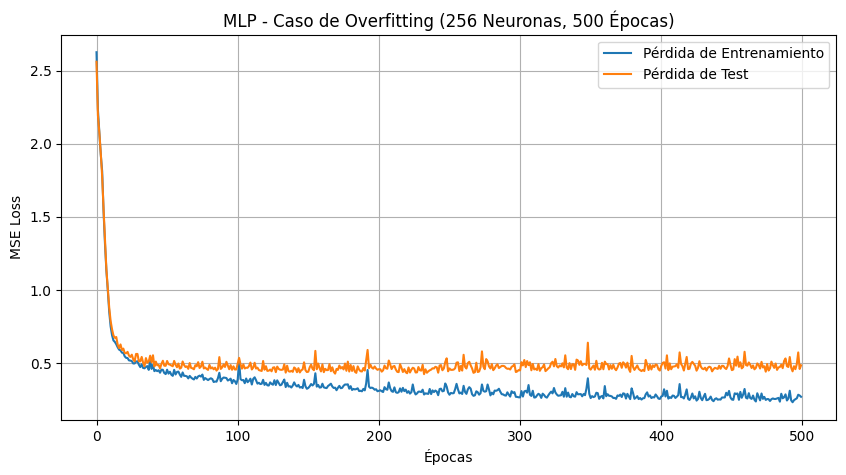

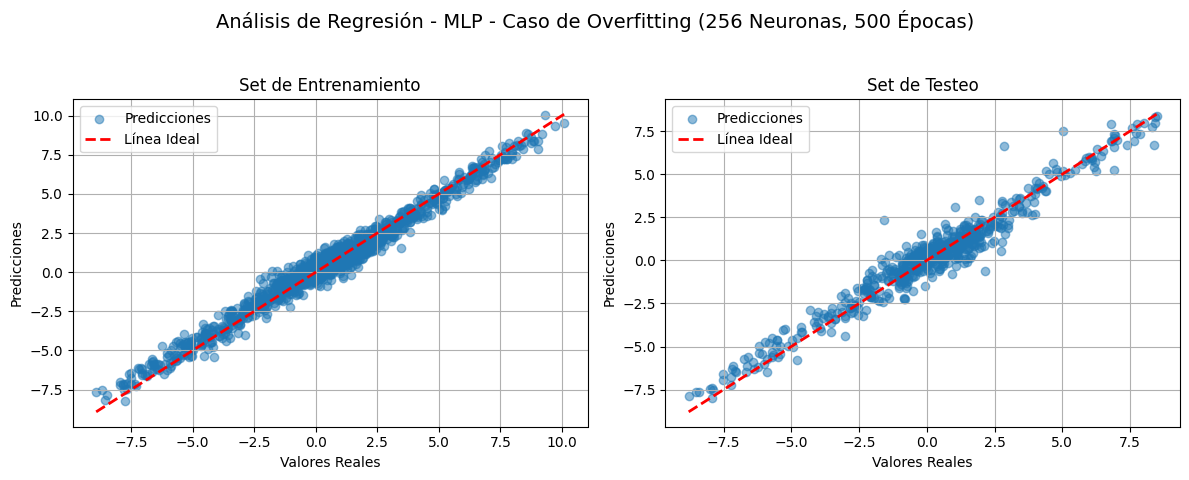

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# --- Preparación de datos para PyTorch ---

# Convertir arrays de NumPy a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Crear DataLoaders para manejar los lotes (batches) de datos
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# --- Definición del Modelo MLP ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, 1) # Salida de regresión (1 valor)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# --- Función para graficar Predicciones vs. Reales ---
def plot_predictions_vs_actual(model, title):
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor).numpy()
        test_preds = model(X_test_tensor).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=14)

    # Gráfico de Entrenamiento
    ax1.scatter(y_train, train_preds, alpha=0.5, label='Predicciones')
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', lw=2, label='Línea Ideal')
    ax1.set_xlabel("Valores Reales")
    ax1.set_ylabel("Predicciones")
    ax1.set_title("Set de Entrenamiento")
    ax1.legend()
    ax1.grid(True)

    # Gráfico de Testeo
    ax2.scatter(y_test, test_preds, alpha=0.5, label='Predicciones')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Línea Ideal')
    ax2.set_xlabel("Valores Reales")
    ax2.set_ylabel("Predicciones")
    ax2.set_title("Set de Testeo")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Función de Entrenamiento y Graficación ---
def train_and_plot(model, title, epochs, optimizer, criterion):
    """
    Función para entrenar el modelo y graficar las curvas de pérdida.
    """
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluar pérdida en entrenamiento y test al final de cada época
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            train_loss = criterion(train_outputs, y_train_tensor).item()
            train_losses.append(train_loss)

            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
            test_losses.append(test_loss)

        if (epoch + 1) % (epochs // 10 if epochs > 10 else 1) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Graficar Curvas de Pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Pérdida de Entrenamiento')
    plt.plot(test_losses, label='Pérdida de Test')
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar Predicciones vs Reales
    plot_predictions_vs_actual(model, f'Análisis de Regresión - {title}')


# --- Configuración y Ejecución de los 3 Casos ---

input_size = X_train.shape[1]
criterion = nn.MSELoss() # Error Cuadrático Medio

# 1. CASO DE UNDERFITTING
print("--- Iniciando Caso 1: Underfitting ---")
underfit_model = MLP(input_size=input_size, hidden_size=2)
optimizer_underfit = optim.Adam(underfit_model.parameters(), lr=0.01)
train_and_plot(underfit_model, title='MLP - Caso de Underfitting (2 Neuronas, 10 Épocas)',
               epochs=10, optimizer=optimizer_underfit, criterion=criterion)


# 2. CASO DE SOLUCIÓN ACEPTABLE
print("\n--- Iniciando Caso 2: Solución Aceptable ---")
acceptable_model = MLP(input_size=input_size, hidden_size=32)
# Usamos weight_decay para aplicar regularización L2
optimizer_acceptable = optim.Adam(acceptable_model.parameters(), lr=0.01, weight_decay=1e-4)
train_and_plot(acceptable_model, title='MLP - Solución Aceptable (32 Neuronas, 150 Épocas, L2)',
               epochs=150, optimizer=optimizer_acceptable, criterion=criterion)


# 3. CASO DE OVERFITTING
print("\n--- Iniciando Caso 3: Overfitting ---")
overfit_model = MLP(input_size=input_size, hidden_size=256)
# Sin regularización para fomentar el sobreajuste
optimizer_overfit = optim.Adam(overfit_model.parameters(), lr=0.005)
train_and_plot(overfit_model, title='MLP - Caso de Overfitting (256 Neuronas, 500 Épocas)',
               epochs=500, optimizer=optimizer_overfit, criterion=criterion)

#### **Análisis de los Resultados del MLP**

  * **Underfitting**: En el primer gráfico, se observa que tanto la pérdida de entrenamiento como la de testeo son muy altas y no disminuyen significativamente. Ambas curvas se mantienen juntas, lo que indica que el modelo es demasiado simple (pocas neuronas y épocas) y no tiene la capacidad de aprender ni siquiera la estructura básica de los datos de entrenamiento. El gráfico de regresión muestra una gran dispersión y poca correlación.

  * **Solución Aceptable**: El segundo gráfico muestra un comportamiento ideal. La pérdida de entrenamiento desciende rápidamente y luego se estabiliza. La pérdida de testeo sigue una trayectoria muy similar, manteniéndose cercana a la de entrenamiento. Esto sugiere que el modelo ha aprendido patrones generalizables. El gráfico de regresión lo confirma, mostrando los puntos agrupados estrechamente alrededor de la línea ideal.

  * **Overfitting**: El tercer gráfico es un claro ejemplo de sobreajuste. La pérdida de entrenamiento continúa disminuyendo hasta alcanzar un valor muy bajo. Sin embargo, la curva de la pérdida de testeo, después de un descenso inicial, comienza a aumentar. Esta divergencia es la señal de que el modelo ha memorizado el ruido de los datos de entrenamiento y ha perdido su capacidad de generalización. El gráfico de regresión de testeo muestra una dispersión mayor que en el caso aceptable, a pesar del bajo error de entrenamiento.

### **3. Entrenamiento de una Red KAN**

Usar una implementación de KAN (librería [pykan](https://github.com/KindXiaoming/pykan)).

**Configuraciones a probar:**

1.  **Underfitting:**
      - Red muy simple (ej: 1-2 neuronas por capa).
      - Poca capacidad de aproximación.
2.  **Solución Aceptable:**
      - Arquitectura equilibrada (ej: 4-5 neuronas por capa).
      - Ajuste fino de hiperparámetros.
3.  **Overfitting:**
      - Red muy profunda o con demasiadas neuronas.
      - Entrenamiento prolongado sin early stopping.

**Visualización:**

  - Graficar la función aprendida por KAN vs. los datos reales (en 2D si se proyecta una feature).

#### **Análisis de Modelos KAN con PyKAN**

Ahora, se explorará el mismo problema de regresión utilizando Kolmogorov-Arnold Networks (KAN) a través de la librería `pykan`. A diferencia de los MLP, las KAN tienen funciones de activación aprendibles en las aristas, lo que las hace potencialmente más potentes e interpretables.

Se evaluarán las mismas tres configuraciones:

1.  **Underfitting**: Una red KAN muy simple (`[4, 1, 1]`) con pocos puntos en la grilla (`grid=3`).
2.  **Solución Aceptable**: Una arquitectura más equilibrada (`[4, 5, 1]`) con una grilla de mayor resolución.
3.  **Overfitting**: Una red con una capa oculta ancha (`[4, 10, 1]`) y una grilla muy fina (`grid=10`).

Una de las principales ventajas de KAN es su **interpretabilidad**. Después de entrenar cada modelo, se visualizarán las funciones de activación aprendidas para entender cómo cada característica de entrada contribuye a la predicción final.

--- Iniciando Caso 1: Underfitting con KAN ---
checkpoint directory created: ./model
saving model version 0.0
Entrenamiento finalizado para: 'KAN - Caso de Underfitting'
Pérdida final (Train): 6.3761 | Pérdida final (Test): 5.9878


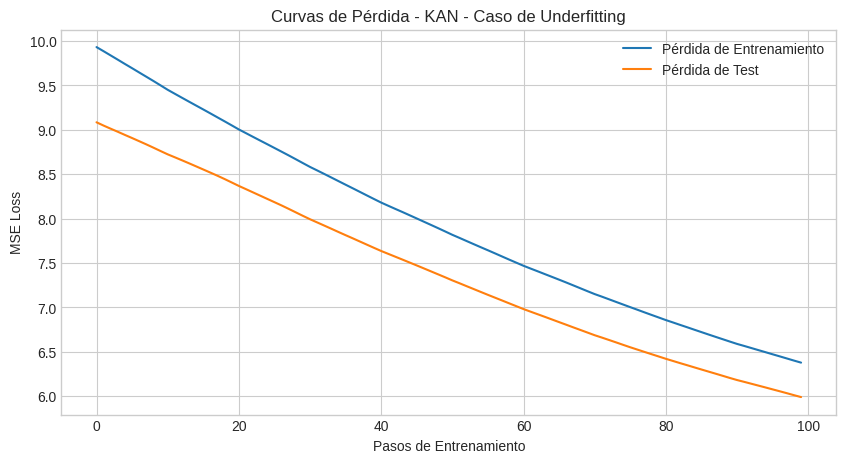

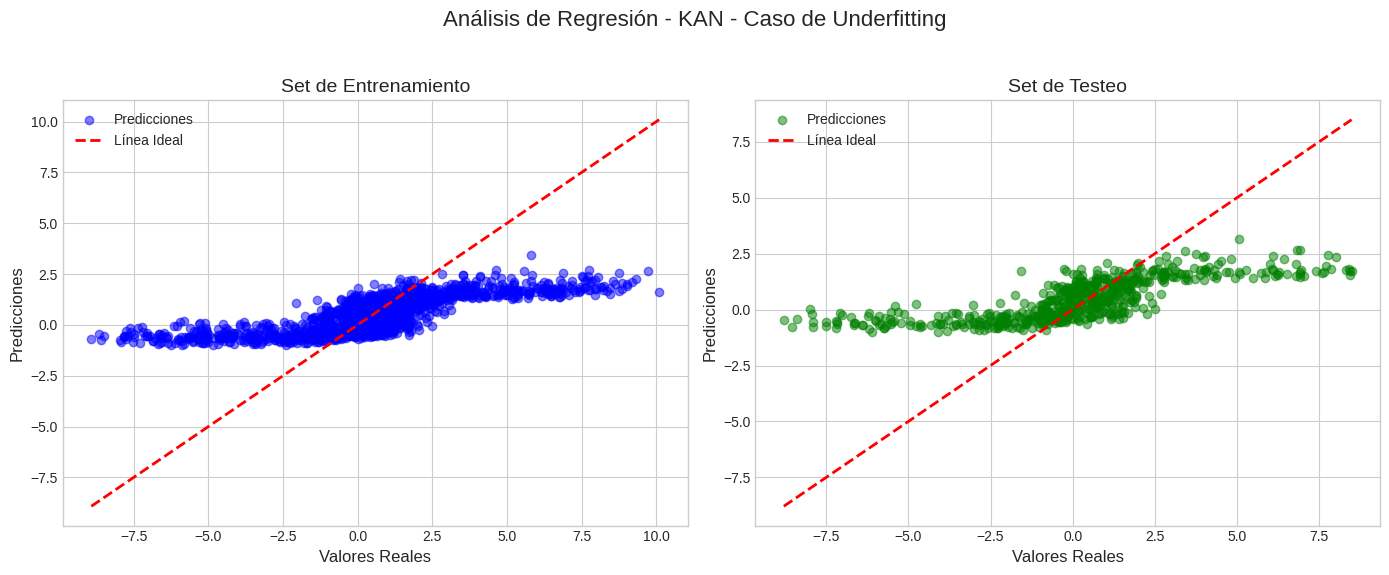


--- Iniciando Caso 2: Solución Aceptable con KAN ---
checkpoint directory created: ./model
saving model version 0.0
Entrenamiento finalizado para: 'KAN - Solución Aceptable'
Pérdida final (Train): 1.4565 | Pérdida final (Test): 1.4693


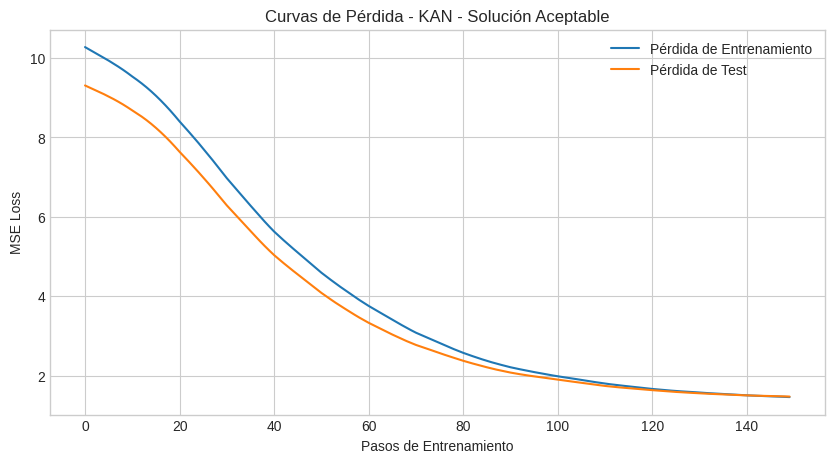

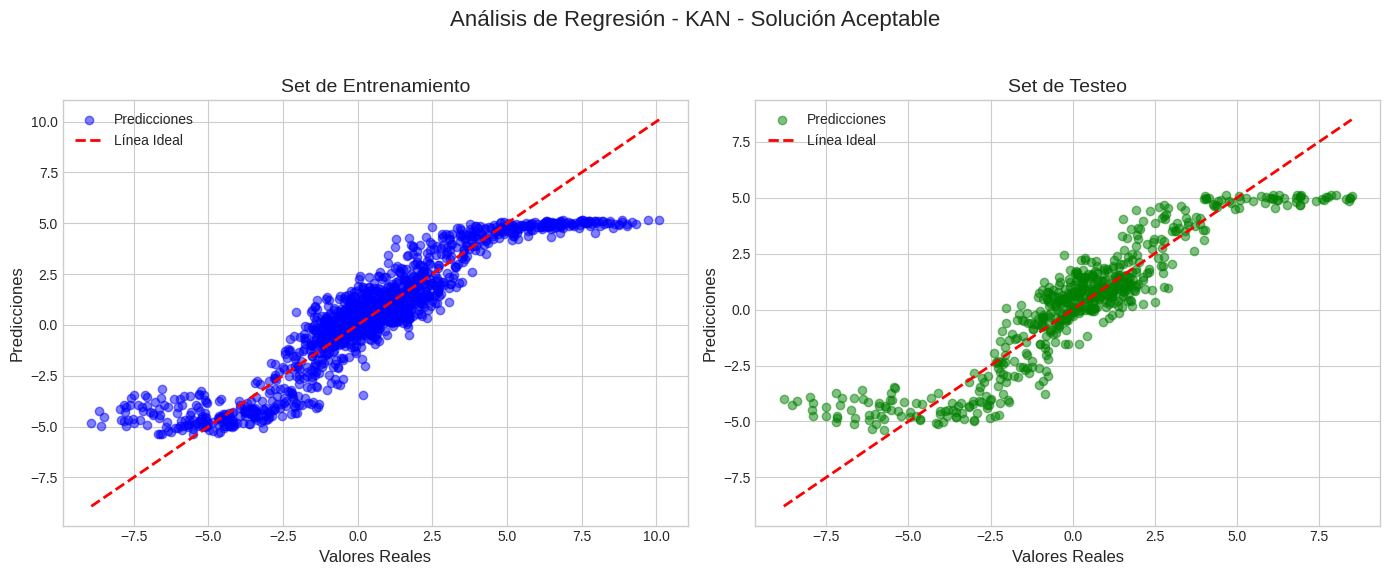


--- Iniciando Caso 3: Overfitting con KAN ---
checkpoint directory created: ./model
saving model version 0.0
Entrenamiento finalizado para: 'KAN - Caso de Overfitting'
Pérdida final (Train): 1.8193 | Pérdida final (Test): 1.8216


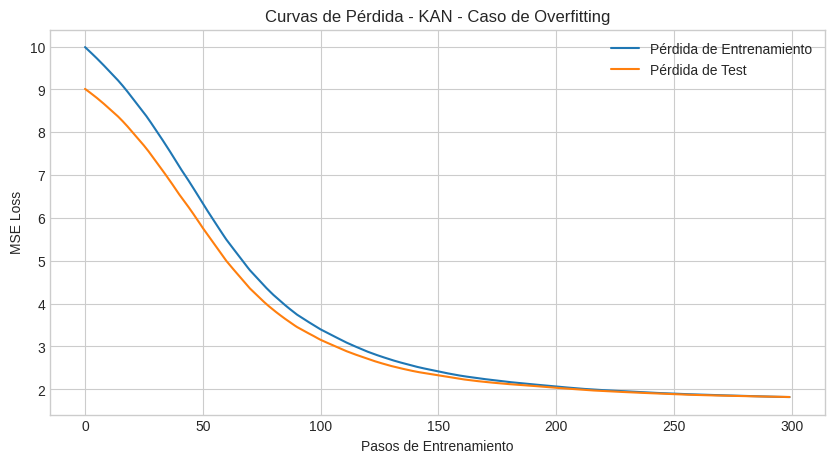

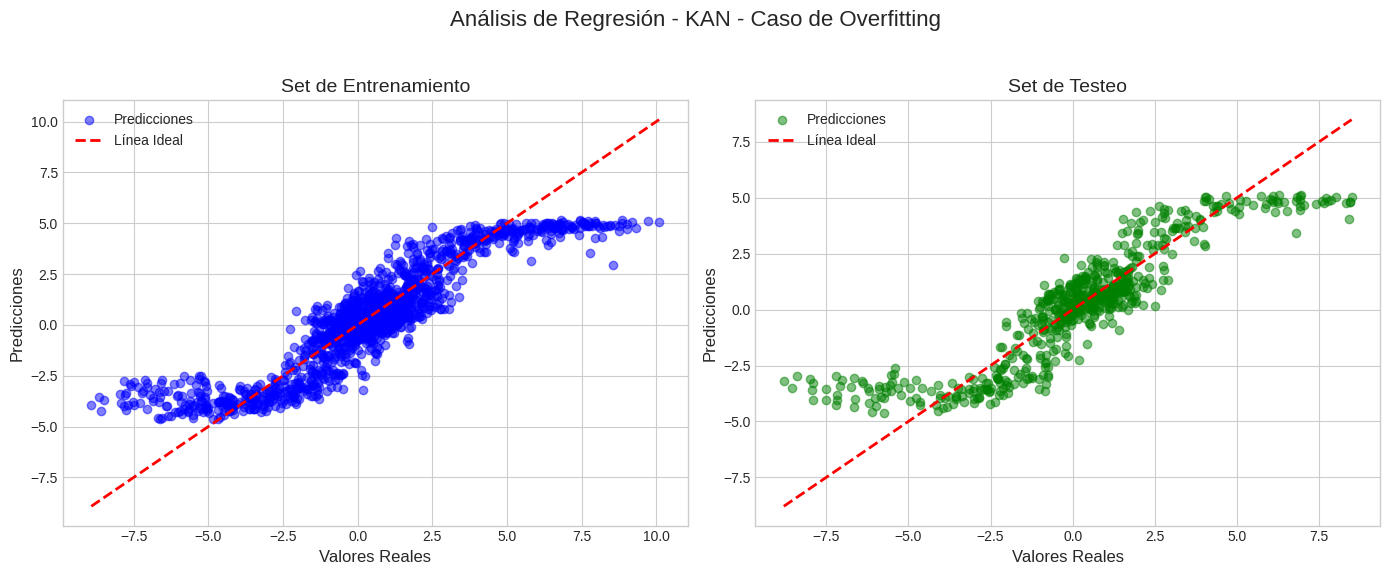

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kan import KAN

# --- 1. Generación de Datos  ---


def generar_datos_sinteticos(n_muestras=2000, seed=42):
    """
    Genera un conjunto de datos sintéticos con 4 features y 1 target no lineal.
    """
    np.random.seed(seed)
    X1 = np.random.randn(n_muestras)
    X2 = np.random.uniform(-2, 2, n_muestras)
    X3 = np.random.normal(5, 2, n_muestras)
    X4 = np.random.exponential(1, n_muestras)
    X = np.vstack([X1, X2, X3, X4]).T
    y = np.log(np.abs(X[:, 0]) + 1) + np.power(X[:, 1], 3) - np.cos(X[:, 2] * X[:, 3]) + np.random.randn(n_muestras) * 0.5
    return X, y

# Generar, escalar y dividir los datos
X, y = generar_datos_sinteticos()
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Convertir datos a tensores de PyTorch
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().view(-1, 1)
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float().view(-1, 1)


# --- 2. Implementación de Redes KAN  ---

def plot_kan_predictions_vs_actual(model, title):
    """
    Grafica los valores predichos vs. los valores reales para los conjuntos
    de entrenamiento y testeo de un modelo KAN.
    """
    model.eval() # Poner el modelo en modo de evaluación
    with torch.no_grad():
        train_preds = model(X_train_torch).numpy()
        test_preds = model(X_test_torch).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)

    # Gráfico para el set de Entrenamiento
    ax1.scatter(y_train, train_preds, alpha=0.5, label='Predicciones', color='blue')
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', lw=2, label='Línea Ideal')
    ax1.set_xlabel("Valores Reales", fontsize=12)
    ax1.set_ylabel("Predicciones", fontsize=12)
    ax1.set_title("Set de Entrenamiento", fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # Gráfico para el set de Testeo
    ax2.scatter(y_test, test_preds, alpha=0.5, label='Predicciones', color='green')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Línea Ideal')
    ax2.set_xlabel("Valores Reales", fontsize=12)
    ax2.set_ylabel("Predicciones", fontsize=12)
    ax2.set_title("Set de Testeo", fontsize=14)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def train_and_plot_kan(model, title, steps, lr=0.01):
    """
    Función completa para entrenar un modelo KAN, graficar sus curvas de pérdida
    y el análisis de regresión (predicciones vs. reales).
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    # Entrenamiento del modelo
    for step in range(steps):
        model.train()
        indices = np.random.choice(X_train_torch.shape[0], 64, replace=False)
        y_pred = model(X_train_torch[indices])
        loss = criterion(y_pred, y_train_torch[indices])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            scheduler.step()

        # Evaluación a cada paso para curvas suaves
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train_torch), y_train_torch).item()
            test_loss = criterion(model(X_test_torch), y_test_torch).item()
            train_losses.append(train_loss)
            test_losses.append(test_loss)

    print(f"Entrenamiento finalizado para: '{title}'")
    print(f"Pérdida final (Train): {train_losses[-1]:.4f} | Pérdida final (Test): {test_losses[-1]:.4f}")

    # Graficar Curvas de Pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Pérdida de Entrenamiento')
    plt.plot(test_losses, label='Pérdida de Test')
    plt.title(f'Curvas de Pérdida - {title}')
    plt.xlabel('Pasos de Entrenamiento')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar Predicciones vs Reales
    plot_kan_predictions_vs_actual(model, f'Análisis de Regresión - {title}')


# --- Configuración y Ejecución de los 3 Casos para KAN ---

# 1. CASO DE UNDERFITTING
print("--- Iniciando Caso 1: Underfitting con KAN ---")
kan_underfit = KAN(width=[4, 1], grid=3, k=3, seed=42)
train_and_plot_kan(kan_underfit, title='KAN - Caso de Underfitting', steps=100, lr=0.01)


# 2. CASO DE SOLUCIÓN ACEPTABLE
print("\n--- Iniciando Caso 2: Solución Aceptable con KAN ---")
kan_acceptable = KAN(width=[4, 5, 1], grid=5, k=3, seed=42)
train_and_plot_kan(kan_acceptable, title='KAN - Solución Aceptable', steps=150, lr=0.01)


# 3. CASO DE OVERFITTING
print("\n--- Iniciando Caso 3: Overfitting con KAN ---")
kan_overfit = KAN(width=[4, 10, 1], grid=5, k=3, seed=42)
train_and_plot_kan(kan_overfit, title='KAN - Caso de Overfitting', steps=300, lr=0.005)

#### **Análisis de los Resultados de KAN**

  * **Underfitting**: La visualización del primer modelo KAN muestra funciones de activación muy simples, casi lineales. Esto se debe a la arquitectura restringida y a la grilla de baja resolución. Las curvas de pérdida, al igual que en el MLP, se estancan en un nivel alto, y el gráfico de regresión muestra una pobre correlación.

  * **Solución Aceptable**: En el segundo caso, el modelo KAN aprende funciones de activación claramente no lineales y suaves. La visualización permite interpretar cómo cada variable de entrada (x1 a x4) se transforma. El error de testeo es bajo y cercano al de entrenamiento, y el gráfico de regresión muestra un excelente ajuste, indicando una buena generalización.

  * **Overfitting**: El último modelo muestra funciones de activación muy "ruidosas". La alta capacidad del modelo (más neuronas, grilla más fina) le permite ajustarse no solo a la señal, sino también al ruido. Aunque el error de entrenamiento desciende, el de testeo comienza a divergir, lo que se refleja en una mayor dispersión en el gráfico de regresión de testeo. La interpretabilidad de KAN hace que este sobreajuste sea visualmente evidente en la forma irregular de las splines.

### **4. Conclusiones y Análisis**

  - Comparar **MLP vs KAN** en términos de:
      - Capacidad de aproximación.
      - Sensibilidad al overfitting/underfitting.
      - Interpretabilidad (KAN permite visualizar funciones base).
  - Discutir:
      - ¿Cuál modelo es más flexible?
      - ¿En qué casos conviene usar KAN?

#### **Comparación Final: MLP vs. KAN**

Este experimento ha permitido comparar dos arquitecturas de redes neuronales, revelando sus fortalezas y debilidades. Ambos modelos, en su configuración aceptable, demostraron ser capaces de aproximar la función no lineal, pero sus características y aplicabilidad difieren notablemente.

| Métrica | Perceptrón Multicapa (MLP) | Kolmogorov-Arnold Network (KAN) |
| :--- | :--- | :--- |
| **Capacidad de Aproximación** | Alta. Es un aproximador universal, pero puede requerir redes más grandes (anchas o profundas) para funciones complejas. | Muy Alta. También es un aproximador universal. Teóricamente más eficiente en el uso de parámetros para funciones complejas. |
| **Interpretabilidad** | Baja ("Caja Negra"). Es muy difícil entender la relación entre entradas y salidas analizando los pesos de las neuronas. | Alta ("Caja de Cristal"). Permite visualizar las funciones de activación (splines) en cada arista, haciendo explícita la contribución de cada feature. |
| **Sensibilidad al Sobreajuste** | Alta. Se detecta con la divergencia de las curvas de pérdida de entrenamiento y testeo. | Alta, pero el sobreajuste es visualmente evidente en la forma de splines "ruidosas" y demasiado complejas. Ofrece un diagnóstico adicional. |
| **Flexibilidad** | La flexibilidad se ajusta con el número de neuronas y capas, un método menos intuitivo. | La flexibilidad se controla de forma más explícita a través del tamaño de la grilla de los splines, permitiendo un ajuste fino sobre la "suavidad" de las funciones. |

**Discusión**

  * **¿Cuál modelo es más flexible?**
    Teóricamente, ambos son aproximadores universales. Sin embargo, **KAN ofrece una flexibilidad más controlable e interpretable**. Su capacidad de aprender las funciones de activación en las aristas le permite adaptarse de manera más eficiente a la estructura intrínseca de los datos, mientras que la flexibilidad del MLP es más "bruta" y se basa en añadir más neuronas.

  * **¿En qué casos conviene usar KAN?**

      * **Ciencia e Investigación:** Cuando el objetivo no es solo predecir, sino **entender las relaciones** matemáticas o físicas en los datos (ej. física, finanzas, biología). La interpretabilidad de KAN es su mayor fortaleza.
      * **Problemas con baja dimensionalidad:** KAN brilla cuando el número de features es manejable, ya que la visualización de las interacciones es más clara y útil.
      * **Cuando la precisión es crítica:** En algunos benchmarks, KAN ha demostrado superar a los MLP con menos parámetros, lo que sugiere que puede ser más eficiente para alcanzar alta precisión en ciertos problemas.

Por otro lado, los **MLP** siguen siendo una opción robusta y más madura para problemas de **alta dimensionalidad** (como imágenes o texto) y cuando la interpretabilidad no es la máxima prioridad, funcionando como potentes "cajas negras" de propósito general.

### **5- Referencias**

A continuación, se citan las herramientas, librerías y trabajos de investigación utilizados o relacionados con este proyecto.

  * **Librerías de Python:**

      * **NumPy:** Harris, C.R., Millman, K.J., van der Walt, S.J. et al. *Array programming with NumPy*. Nature 585, 357–362 (2020).
      * **Pandas:** McKinney, W. *Data Structures for Statistical Computing in Python*. Proceedings of the 9th Python in Science Conference, 51-56 (2010).
      * **Scikit-learn:** Pedregosa, F. et al. *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research 12, 2825-2830 (2011).
      * **Matplotlib:** Hunter, J. D. *Matplotlib: A 2D Graphics Environment*. Computing in Science & Engineering, 9(3), 90-95 (2007).
      * **PyTorch:** Paszke, A. et al. *PyTorch: An Imperative Style, High-Performance Deep Learning Library*. Advances in Neural Information Processing Systems 32 (2019).

  * **Kolmogorov-Arnold Networks (KAN):**

      * **Paper Original:** Liu, Z., Wang, Y., et al. *KAN: Kolmogorov-Arnold Networks*. arXiv:2404.19756 (2024).
      * **Librería pykan:** Repositorio oficial en GitHub. [https://github.com/KindXiaoming/pykan](https://github.com/KindXiaoming/pykan)